In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys, shutil, copy, time, random

import sys
sys.path.append('../../')

In [2]:
from torchuq.metric.distribution import plot_cdf, plot_icdf, plot_density, plot_reliability_diagram
from torchuq.metric import distribution, quantile, interval
from torchuq.transform.naive import *
from torchuq.transform.conformal import *
from torchuq.transform.basic import *

/sailhome/zhaosj12/.pyenv/versions/3.8.3/lib/python3.8/site-packages/torch/distributions/distribution.py:151: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


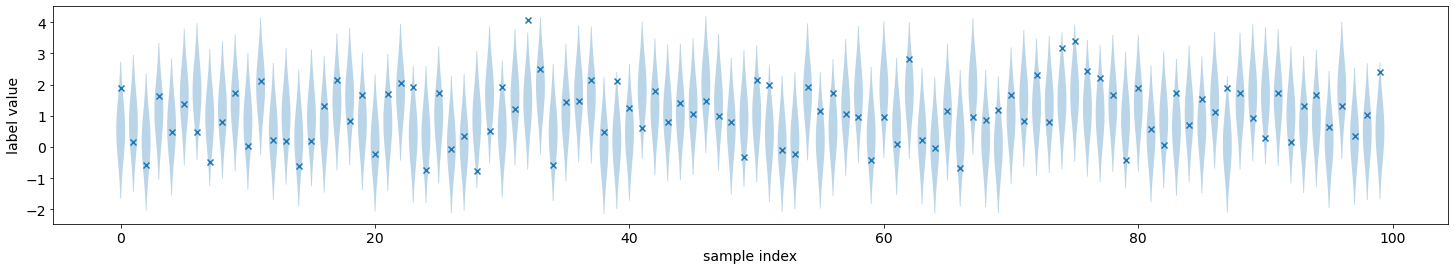

In [3]:
# Convert distribution to other representations
n_pred = 200
pred_distribution = Normal(loc=torch.linspace(0, 2, n_pred)[torch.randperm(n_pred)], scale=torch.ones(n_pred))
labels = pred_distribution.sample() 

distribution.plot_density(pred_distribution, labels)

pred_point = distribution_to_point(pred_distribution, functional='mean')

pred_interval = distribution_to_interval(pred_distribution, confidence=0.9)
# interval.plot_intervals(pred_interval, labels)

pred_quantile = distribution_to_quantile(pred_distribution, n_quantiles=10)
# quantile.plot_quantiles(pred_quantile, labels)

pred_quantile2 = distribution_to_quantile(pred_distribution, quantiles=torch.linspace(0, 1, 12)[1:-1].pow(3))   # Get a strange quantile choice to make sure things still work
# quantile.plot_quantiles(pred_quantile2, labels)

pred_particle = distribution_to_particle(pred_distribution, n_particles=30)

prediction_list = [pred_distribution, pred_point, pred_interval, pred_quantile, pred_quantile2, pred_particle]
prediction_type = ['distribution', 'point', 'interval', 'quantile', 'quantile', 'particle']

### Unit tests for non-conformity scores

In [4]:
# Test to check that score and iscore are indeed inverse of each other
values = torch.linspace(1, 2, 100).view(-1, 1)
for prediction, ptype in zip(prediction_list, prediction_type):
    reconstruction = conformal_iscore_functions[ptype](prediction, conformal_score_functions[ptype](prediction, values))
    print(reconstruction.shape, (reconstruction - values).abs().sum())  # The shape should be [100, 200] and all the reconstruction error should be 0
    
# Test to check that iscore and score are indeed inverse of each other (other composition direction)
values = torch.linspace(0, 1, 100).view(-1, 1)
for prediction, ptype in zip(prediction_list, prediction_type):
    reconstruction = conformal_score_functions[ptype](prediction, conformal_iscore_functions[ptype](prediction, values))
    print(reconstruction.shape, (reconstruction - values).abs().sum())  # The shape should be [100, 200] and all the reconstruction error should be 0

torch.Size([100, 200]) tensor(0.0011)
torch.Size([100, 200]) tensor(6.7353e-05)
torch.Size([100, 200]) tensor(0.0009)
torch.Size([100, 200]) tensor(0.0017)
torch.Size([100, 200]) tensor(0.0027)
torch.Size([100, 200]) tensor(0.0035)
torch.Size([100, 200]) tensor(0.0001)
torch.Size([100, 200]) tensor(0.0006)
torch.Size([100, 200]) tensor(0.0002)
torch.Size([100, 200]) tensor(0.0004)
torch.Size([100, 200]) tensor(0.0011)
torch.Size([100, 200]) tensor(0.0033)


### End to end tests

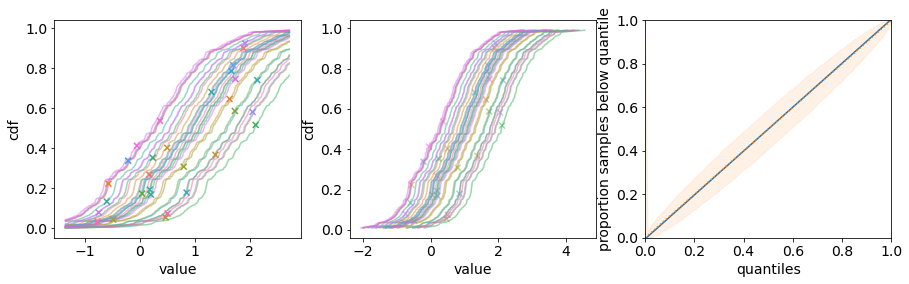

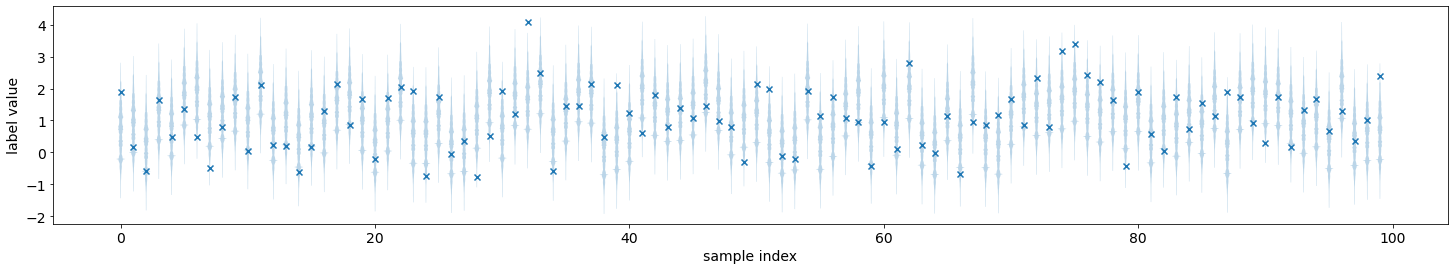

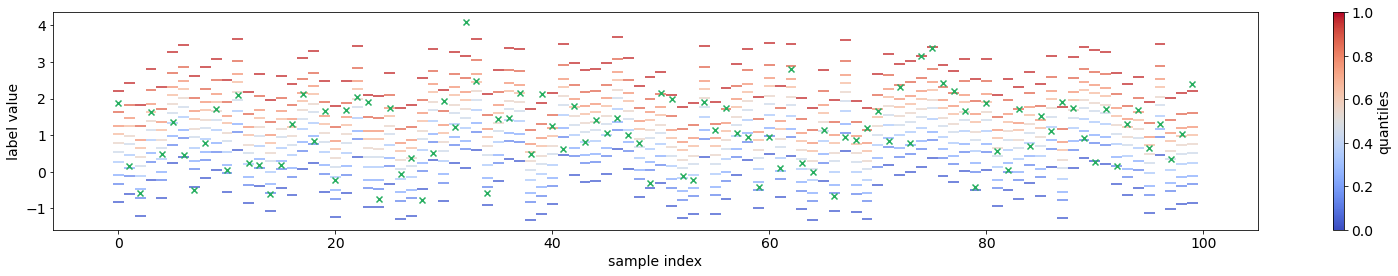

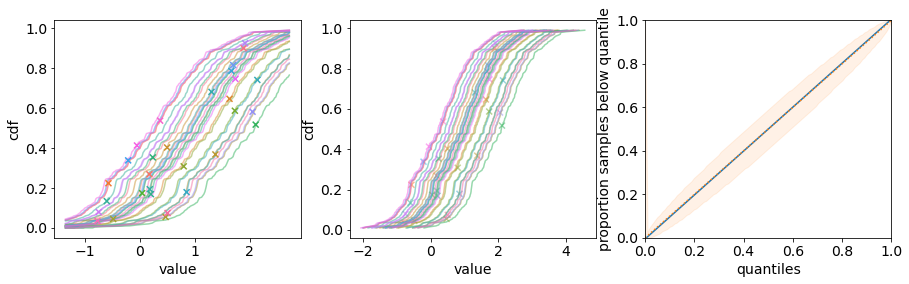

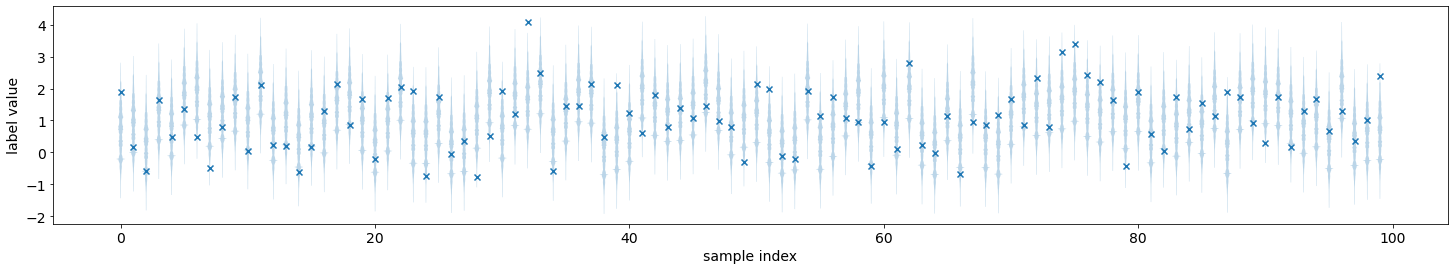

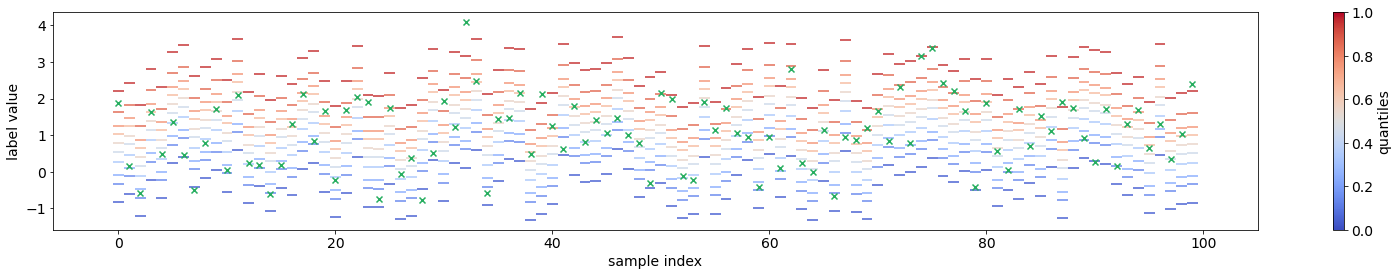

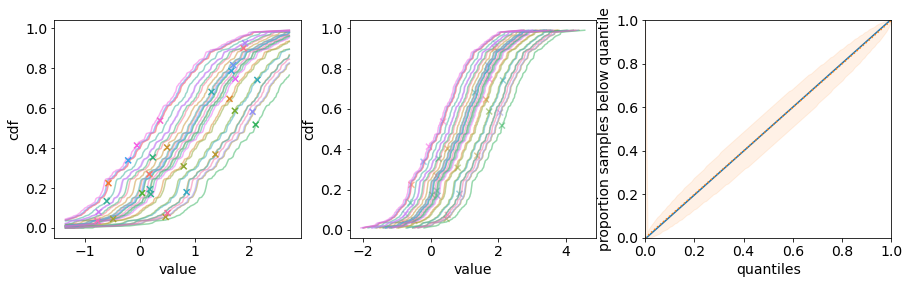

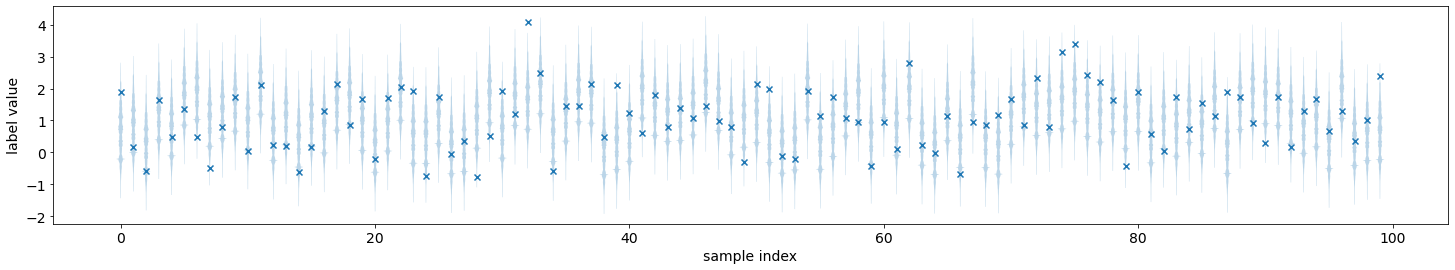

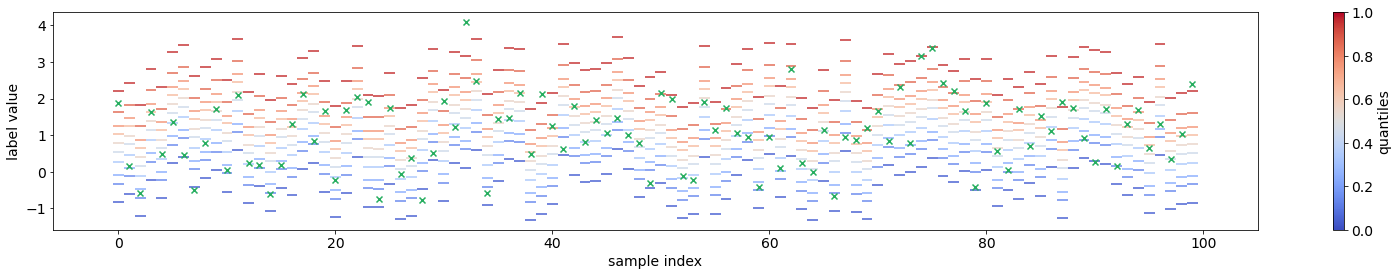

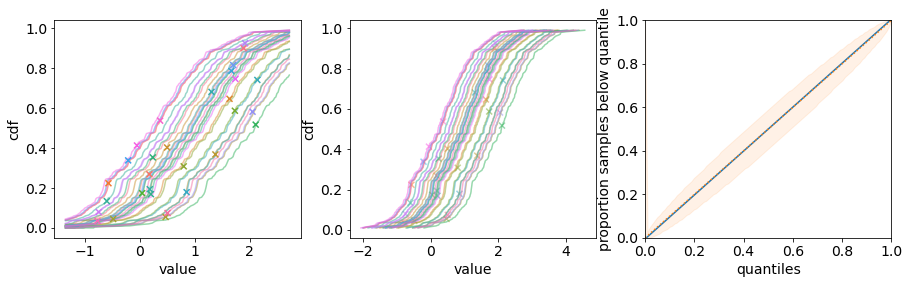

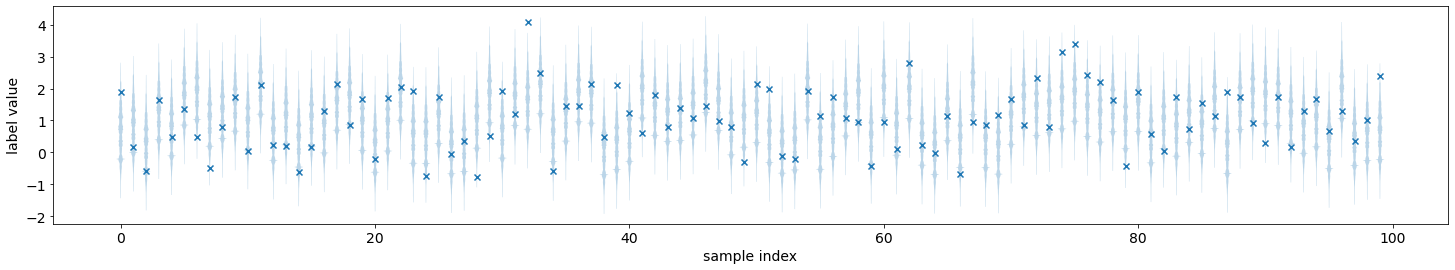

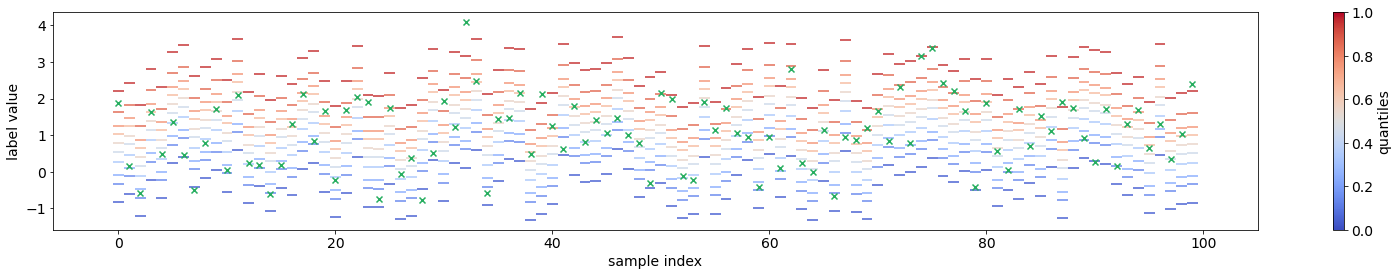

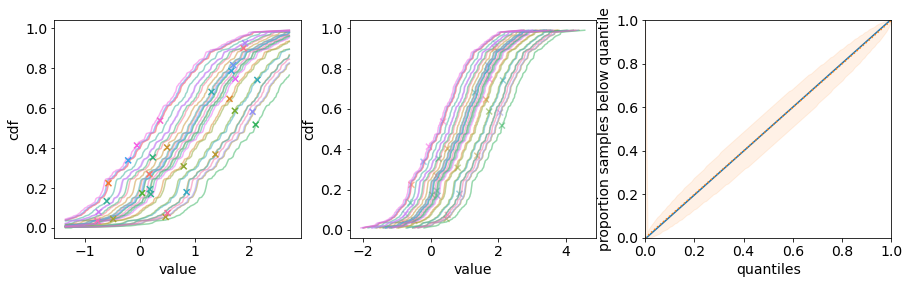

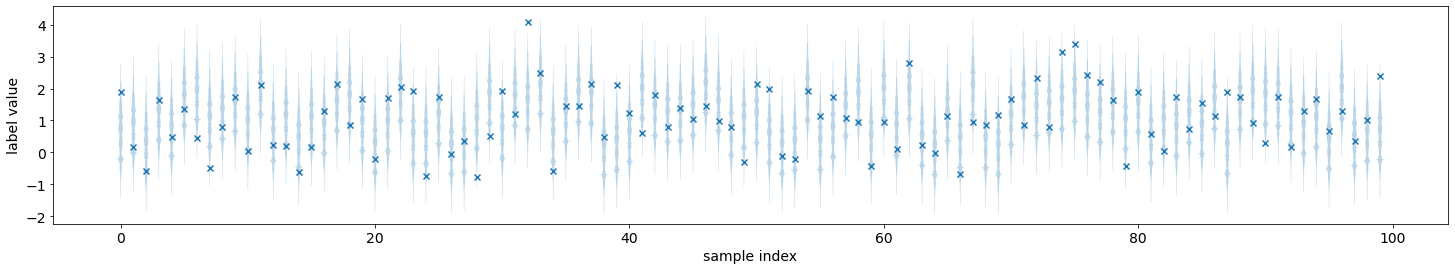

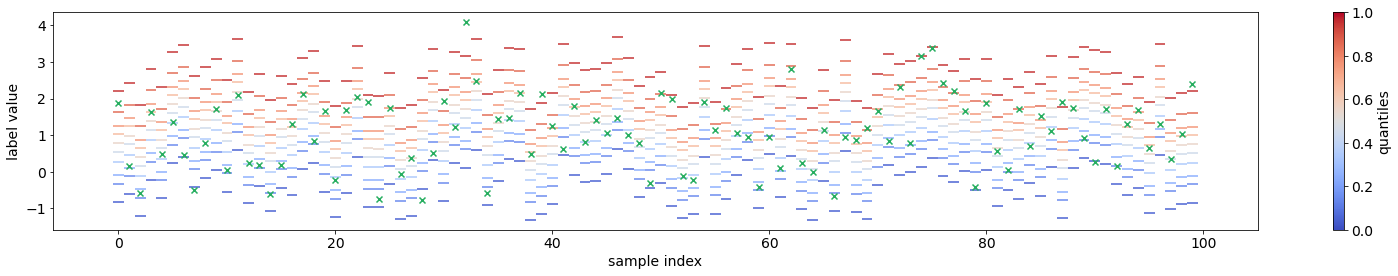

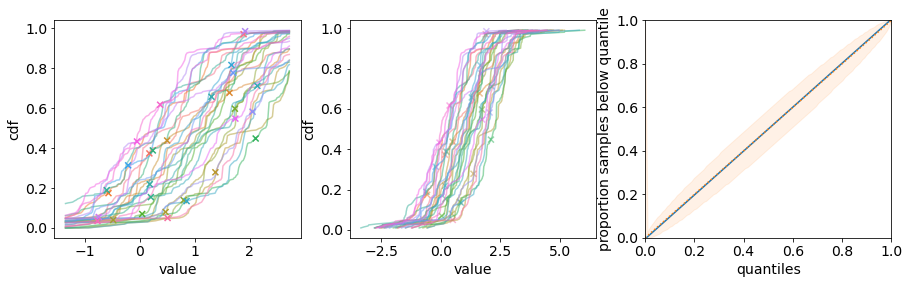

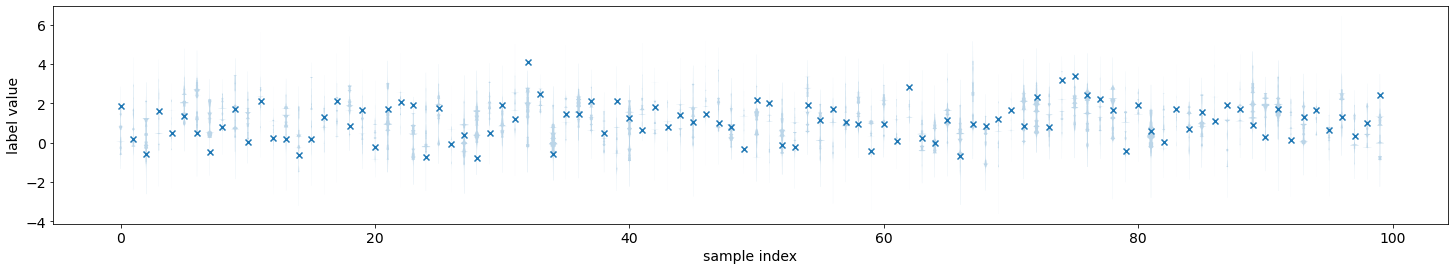

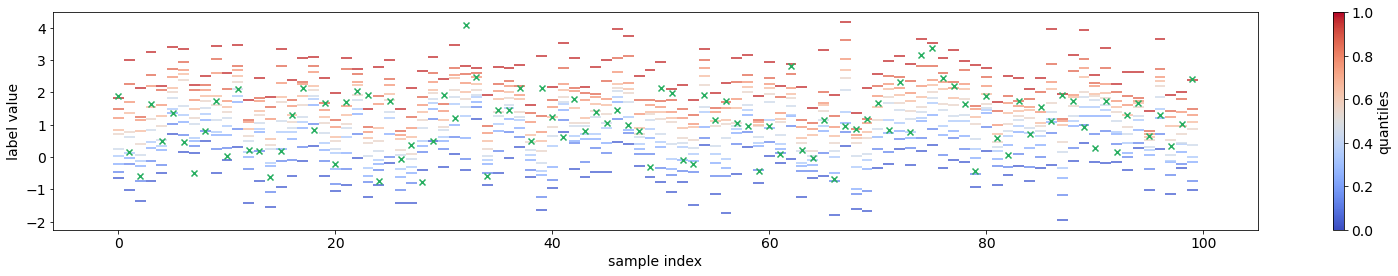

In [5]:
# Test the batch version
for prediction, ptype in zip(prediction_list, prediction_type):
    calibrator = ConformalCalibrator(input_type=ptype, interpolation='linear')
    calibrator.train(prediction, labels)
    pred_calibrated = calibrator(prediction)   

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    plot_cdf(pred_calibrated, labels, ax=axs[0])
    plot_icdf(pred_calibrated, labels, ax=axs[1])
    plot_reliability_diagram(pred_calibrated, labels, ax=axs[2])
    plot_density(pred_calibrated, labels, max_count=100, smooth_bw=3)
    quantile.plot_quantiles(distribution_to_quantile(pred_calibrated, n_quantiles=10), labels)

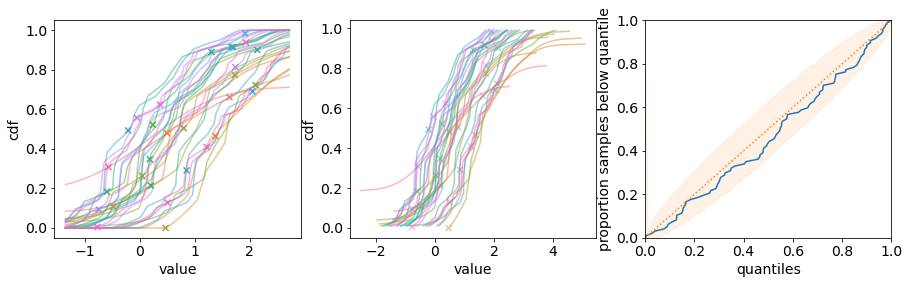

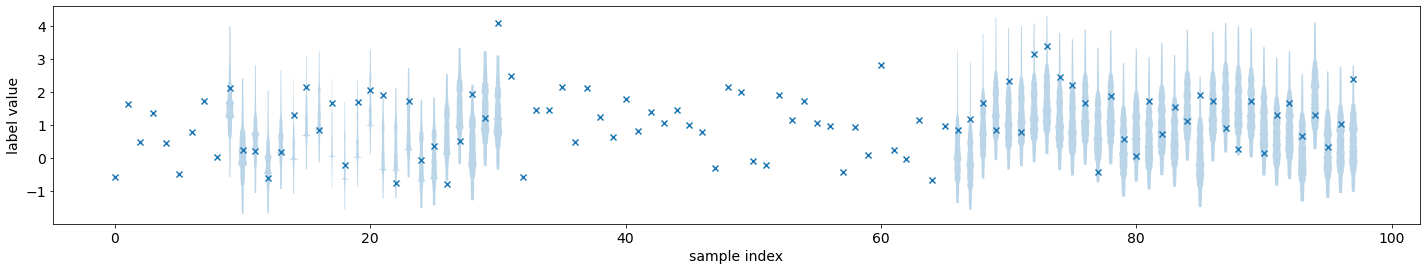

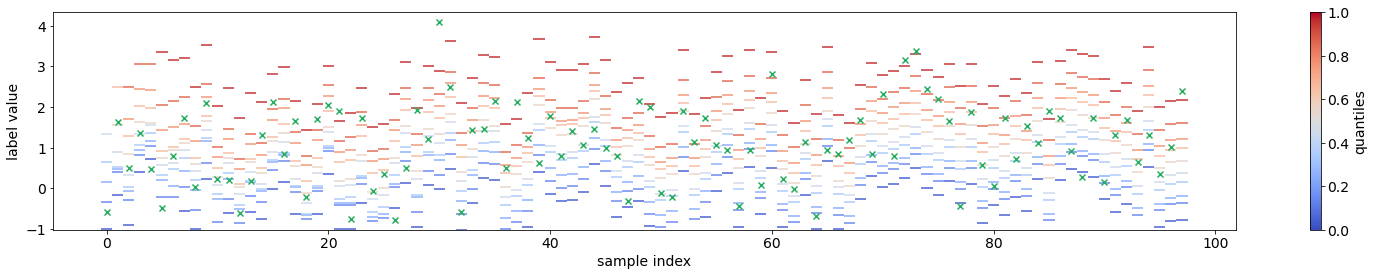

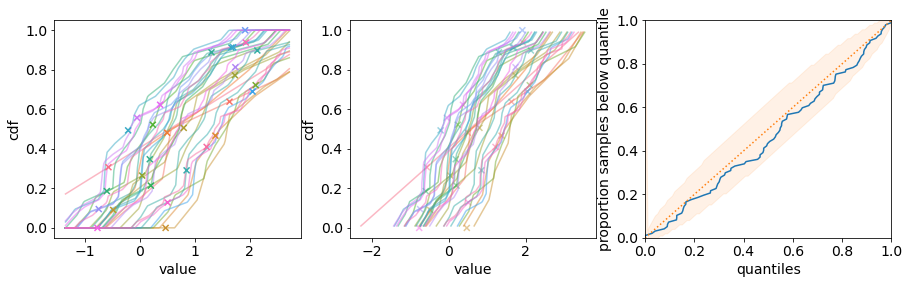

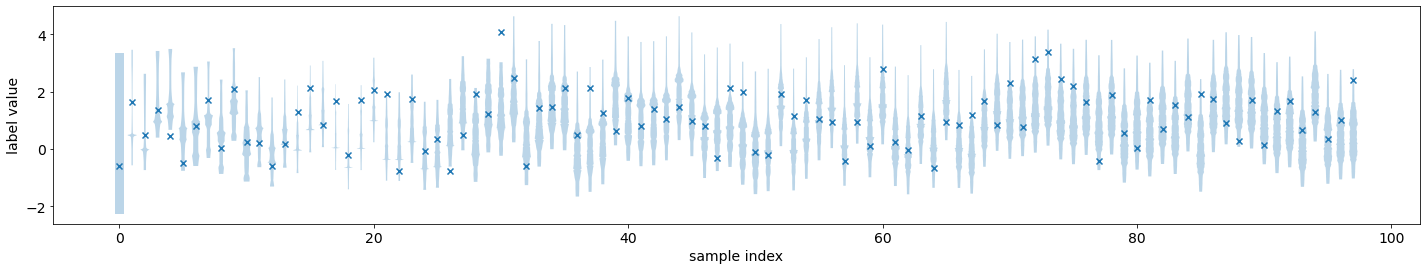

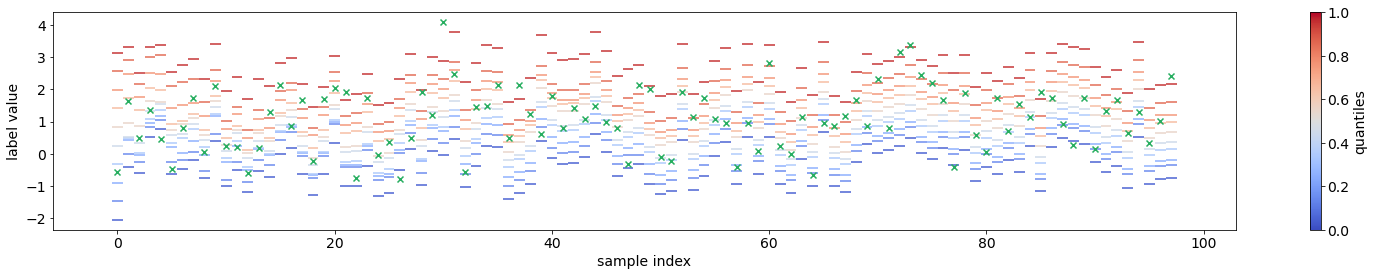

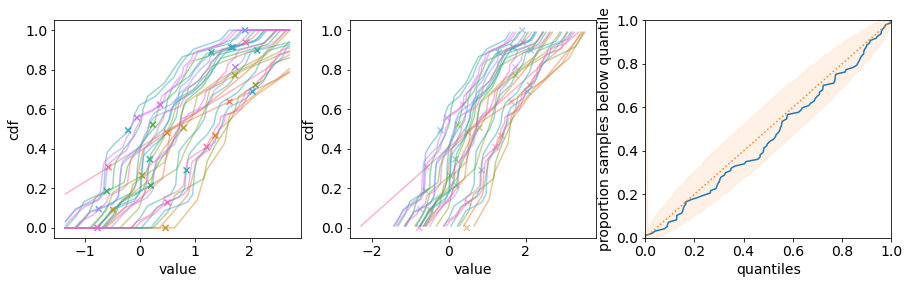

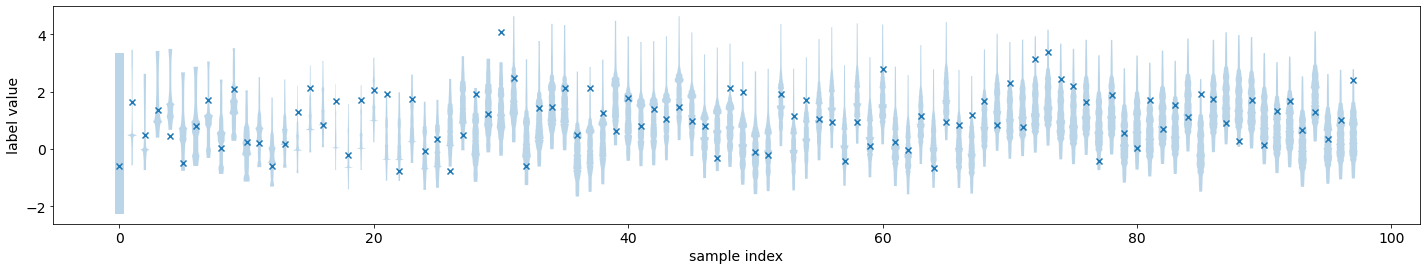

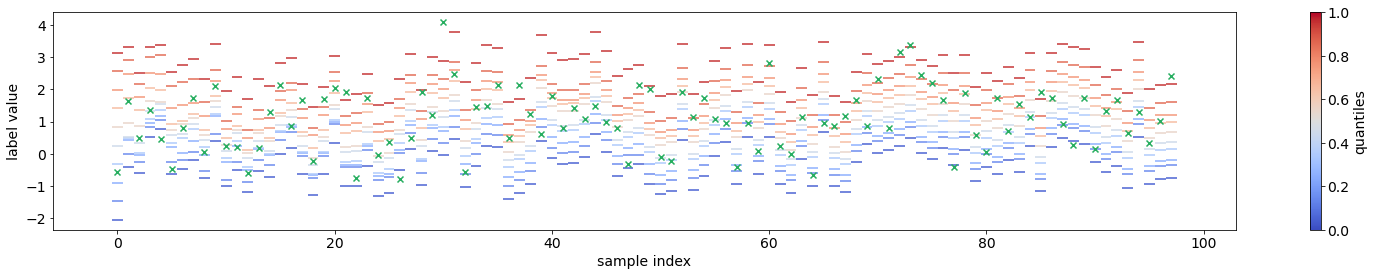

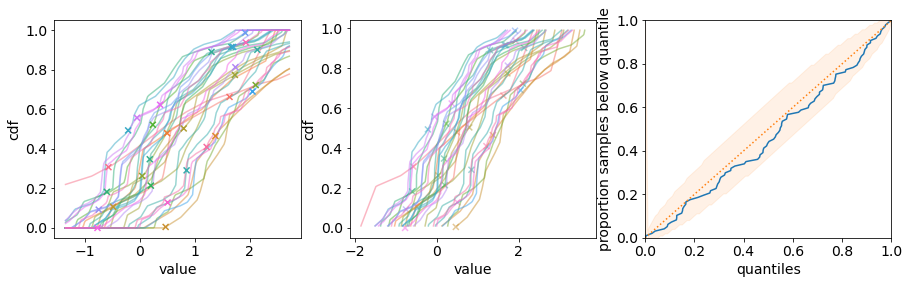

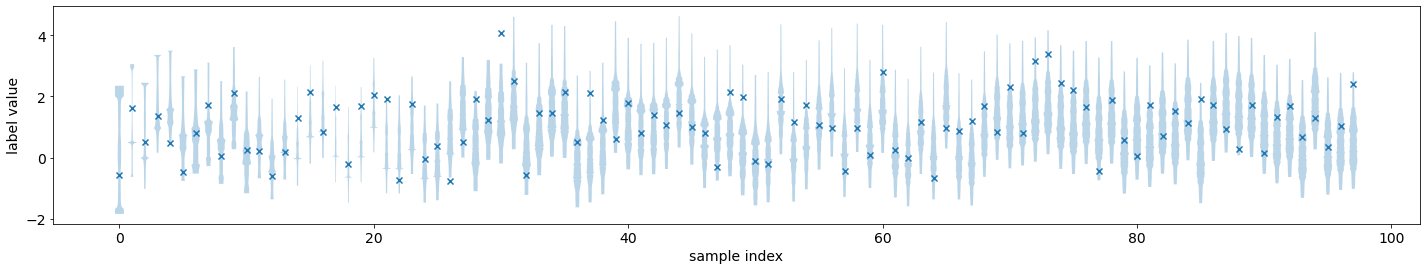

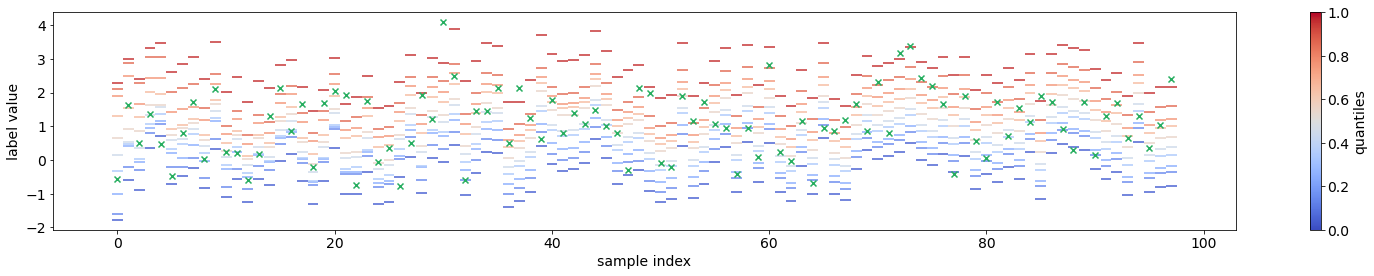

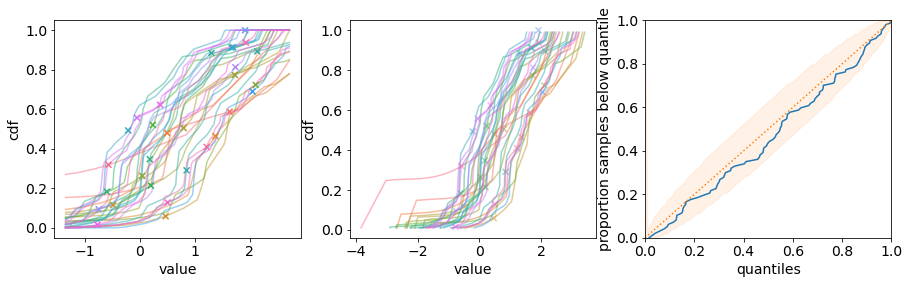

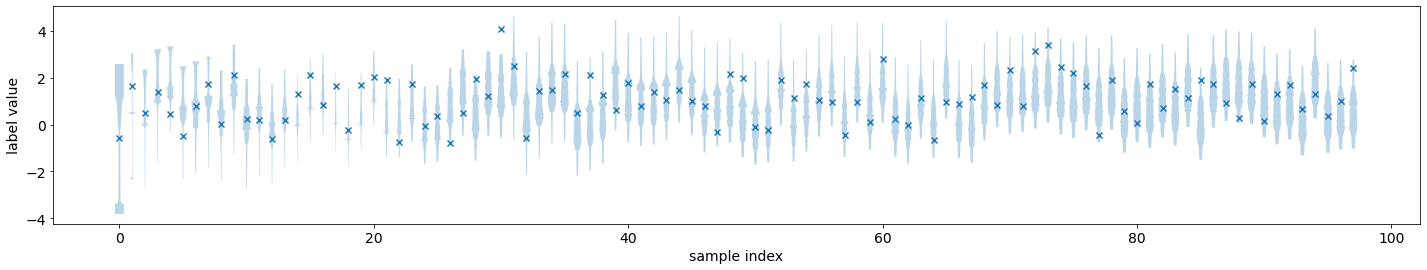

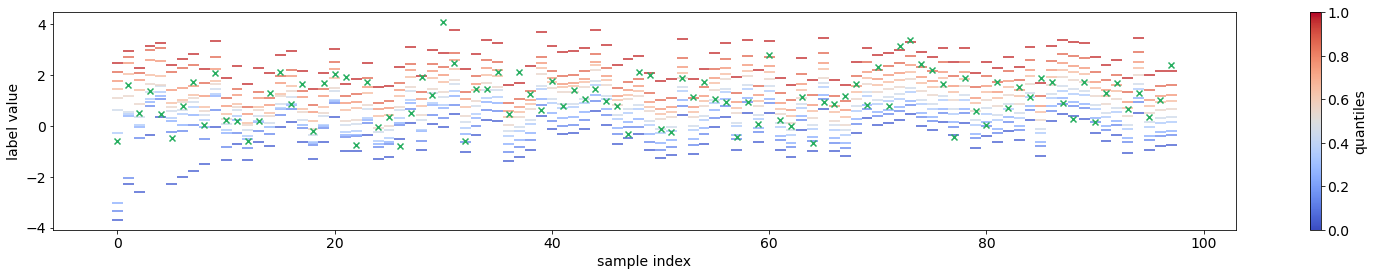

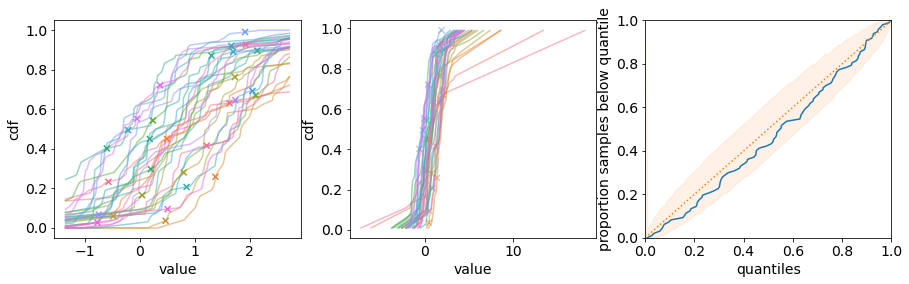

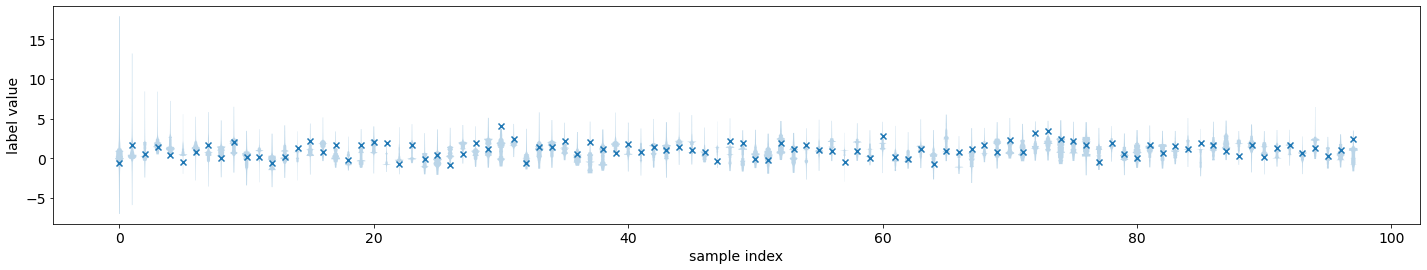

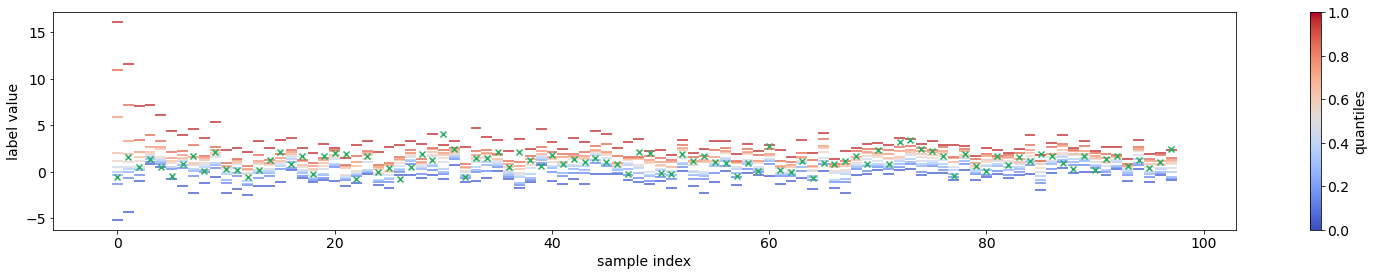

In [6]:
# Test the online version

for prediction, ptype in zip(prediction_list, prediction_type):
    calibrator = ConformalCalibrator(input_type=ptype, interpolation='linear')
    
    history = []
    for t in range(100): 
        if ptype == 'distribution':
            sliced = Normal(loc=prediction.loc[t:t+1], scale=prediction.scale[t:t+1])
        else:
            sliced = prediction[t:t+1]
        if t > 1:
            pred_calibrated = calibrator(sliced)   
            history.append(pred_calibrated)
        calibrator.update(sliced, labels[t:t+1])
    history = ConcatDistribution(history) 
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    plot_cdf(history, labels[2:100], ax=axs[0])
    plot_icdf(history, labels[2:100], ax=axs[1])
    plot_reliability_diagram(history, labels[2:100], ax=axs[2])
    plot_density(history, labels[2:100], max_count=100, smooth_bw=10)
    quantile.plot_quantiles(distribution_to_quantile(history, n_quantiles=10), labels[2:100])